In [2]:
import torch_lddmm_jt as torch_lddmm
import numpy as np
import matplotlib.pyplot as plt
import torch
import SimpleITK as sitk
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Define useful functions (copied from ndreg)

In [3]:
def imgHM(inImg, refImg, numMatchPoints=64, numBins=256, thresholdAtMean=False):
    """
    Histogram matches input image to reference image and writes result to output image
    """
    inImg = sitk.Cast(inImg, refImg.GetPixelID())
    return  sitk.HistogramMatchingImageFilter().Execute(inImg, refImg, numBins, numMatchPoints, thresholdAtMean)

def imgChecker(inImg, refImg, useHM=True, pattern=[4]*3):
    """
    Checkerboards input image with reference image
    """    
    inImg = sitk.Cast(inImg, refImg.GetPixelID())
    inSize = list(inImg.GetSize())
    refSize = list(refImg.GetSize())

    if(inSize != refSize):
        sourceSize = np.array([inSize, refSize]).min(0)
        tmpImg = sitk.Image(refSize,refImg.GetPixelID()) # Empty image with same size as reference image
        tmpImg.CopyInformation(refImg)
        inImg = sitk.PasteImageFilter().Execute(tmpImg, inImg, sourceSize, zeroIndex, zeroIndex)

    if useHM: inImg = imgHM(inImg, refImg)
        
    return sitk.CheckerBoardImageFilter().Execute(inImg, refImg,pattern)


def imgReorient(inImg, inOrient, outOrient):
    """
    Reorients image from input orientation inOrient to output orientation outOrient.
    inOrient and outOrient must be orientation strings specifying the orientation of the image.
    For example an orientation string of "las" means that the ...
        x-axis increases from \"l\"eft to right
        y-axis increases from \"a\"nterior to posterior
        z-axis increases from \"s\"uperior to inferior
    Thus using inOrient = "las" and outOrient = "rpi" reorients the input image from left-anterior-superior to right-posterior-inferior orientation.
    """
    dimension = 3
    identityDirection = [1,0,0, 0,1,0, 0,0,1]
    zeroOrigin = [0]*dimension

    if (len(inOrient) != dimension) or not isinstance(inOrient, str): raise Exception("inOrient must be a string of length {0}.".format(dimension))
    if (len(outOrient) != dimension) or not isinstance(outOrient, str): raise Exception("outOrient must be a string of length {0}.".format(dimension))
    inOrient = str(inOrient).lower()
    outOrient = str(outOrient).lower()
    
    inDirection = ""
    outDirection = ""
    orientToDirection = {"r":"r", "l":"r", "s":"s", "i":"s", "a":"a", "p":"a"}
    for i in range(dimension):
        try:
            inDirection += orientToDirection[inOrient[i]]
        except:
            raise Exception("inOrient \'{0}\' is invalid.".format(inOrient))

        try:
            outDirection += orientToDirection[outOrient[i]]
        except:
            raise Exception("outOrient \'{0}\' is invalid.".format(outOrient))
    
    if len(set(inDirection)) != dimension: raise Exception("inOrient \'{0}\' is invalid.".format(inOrient))
    if len(set(outDirection)) != dimension: raise Exception("outOrient \'{0}\' is invalid.".format(outOrient))

    order = []
    flip = []
    for i in range(dimension):
        j = inDirection.find(outDirection[i])
        order += [j]
        flip += [inOrient[j] != outOrient[i]]

    outImg = sitk.PermuteAxesImageFilter().Execute(inImg, order)
    outImg = sitk.FlipImageFilter().Execute(outImg, flip, False)
    outImg.SetDirection(identityDirection)
    outImg.SetOrigin(zeroOrigin)
    return outImg

def imgSliceAlign(inImg, refImg, inSigma=50, refSigma=10, numIterations=50):
    target_resample_arr = np.transpose(sitk.GetArrayFromImage(inImg),[2,1,0])
    mri_transform_arr = np.transpose(sitk.GetArrayFromImage(refImg),[2,1,0])

    lddmm = torch_lddmm.LDDMM(template=[mri_transform_arr],target=[target_resample_arr],costmask=None,outdir='../notebook/',do_affine=2,do_lddmm=0,a=8,niter=150,epsilon=5e-3,sigma=[20.0],sigmaR=10.0,optimizer='gdr',
                          dx=output_spacing,cc=0,gpu_number = None,checkaffinestep=1)
    lddmm._checkParameters()
    lddmm._load(lddmm.params['template'],lddmm.params['target'],lddmm.params['costmask'])
    lddmm.initializeVariables()
    lddmm.initializeKernels()

    epsilonxy = 4e-7#4e-7
    epsilontheta=2e-7#2e-7
    a = None
    b = None
    theta = None
    niter = numIterations
    sigma_atlas_radius = 1
    #lddmm.setParams('a',4)
    a,b,theta,outtarget,epsilonxy,epsilontheta = lddmm.sa(torch.tensor(target_resample_arr).type(torch.FloatTensor),torch.tensor(mri_transform_arr).type(torch.FloatTensor),niter=niter,dim=2,norm=0,missingslices=[],sigma_atlas=refSigma,sigma_target=inSigma,a=a,b=b,theta=theta,nx=list(target_resample_arr.shape),dx=output_spacing,epsilonxy=epsilonxy*4, epsilontheta=epsilontheta*4, sigma_target_radius=1, sigma_atlas_radius=sigma_atlas_radius) 

    target_resample_arr = np.transpose(sitk.GetArrayFromImage(inImg),[2,1,0])
    #mri_transform_arr = np.transpose(sitk.GetArrayFromImage(mri_affine),[2,1,0])

    outtarget = lddmm.applySA(torch.tensor(target_resample_arr).type(torch.FloatTensor), a, b, theta, dim=2,nx=list(target_resample_arr.shape),dx=inImg.GetSpacing()).numpy().astype(np.float32)
    outImg = sitk.GetImageFromArray(np.transpose(outtarget,(2,1,0)))
    outImg.SetSpacing(inImg.GetSpacing())
    return outImg, lddmm

def imgAffine(inImg, refImg, numIterations=50):

    mri_transform_arr = np.transpose(sitk.GetArrayFromImage(inImg),[2,1,0])
    outtarget = np.transpose(sitk.GetArrayFromImage(refImg),[2,1,0])
    costmask = np.ones(outtarget.shape)

    lddmm = torch_lddmm.LDDMM(template=[mri_transform_arr],target=[outtarget],costmask=costmask,outdir='../notebook/',do_affine=2,do_lddmm=0,a=8,niter=150,epsilon=5e-3,sigma=[20.0],sigmaR=10.0,optimizer='gdr',
                              dx=list(refImg.GetSpacing()),cc=1,gpu_number = None)


    #%%time
    lddmm.setParams('niter',numIterations)
    # translation
    lddmm.setParams('epsilonL',1e-99)
    lddmm.setParams('epsilonT',2e-5)
    lddmm.run()
    # translation + rotation
    lddmm.setParams('epsilonL',1e-5)
    lddmm.setParams('epsilonT',2e-5)
    lddmm.run()
    # affine
    lddmm.setParams('do_affine',1)
    lddmm.setParams('epsilonL',1e-5)
    lddmm.setParams('epsilonT',2e-5)
    lddmm.run()

    # 
    print(lddmm.affineA)

    mri_transform_arr = (lddmm.applyThisTransform(mri_transform_arr))[0][-1].cpu().numpy()
    mri_affine = sitk.GetImageFromArray(np.transpose(mri_transform_arr,(2,1,0)))
    mri_affine.SetSpacing(refImg.GetSpacing())
    return mri_affine, lddmm


***Read Images***

In [4]:
# Load histology
inDirPath = '/Users/jennytrieu/Desktop/deafcats/'
outDirPath = '/Users/jennytrieu/Desktop/deafcats/'

target_file_name = inDirPath + 'H28G15_SMI_compiled.nii'
target_sitk = sitk.ReadImage(target_file_name)

# Load MR volume
mri_file_name = inDirPath + "MaskData_Original.nrrd"
mri_sitk = sitk.ReadImage(mri_file_name)

# Reorient MR volume to histology
mri_sitk = imgReorient(mri_sitk,"RPS", "SLA")

***Understanding Image Dimensions***

In [5]:
# Dimensions of Histology Images
d = [num for num in target_sitk.GetSize()]
print("Target Histology Dimensions: " + str(d))

# Dimensions of MRI Images
d = [num for num in mri_sitk.GetSize()]
print("MRI Dimensions: " + str(d))

Target Histology Dimensions: [3927, 2697, 60]
MRI Dimensions: [96, 150, 192]


***Visualizing Raw Histology and MRI Data***

In [6]:
# Visualize Histology and MRI slices
from ipywidgets import FloatSlider

def show_single_volume(image,z_image, im_title):
    plt.figure(figsize=(4,10))
    
    plt.imshow(np.transpose(sitk.GetArrayFromImage(image),(2,1,0))[:,:,z_image])
    plt.title(f"{im_title} slice #{str(z_image)}")
    
interact(show_single_volume,image = fixed(target_sitk),
                     z_image =widgets.IntSlider(min=0, max=59, step=1, value=10), im_title=fixed("Histology"))
interact(show_single_volume,image = fixed(mri_sitk),
                     z_image =widgets.IntSlider(min=0, max=191, step=1, value=120), im_title=fixed("MRI"))
              

interactive(children=(IntSlider(value=10, description='z_image', max=59), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=120, description='z_image', max=191), Output()), _dom_classes=('widget-i…

<function __main__.show_single_volume(image, z_image, im_title)>

**Resample the Histology and MRI to have the same output spacing**

***Resample History***

In [7]:
# Resample target (histology) image
mriScaleFactor = 4
pad_amount = [15,15,4]

output_spacing = [mri_sitk.GetSpacing()[0]/mriScaleFactor,
                  mri_sitk.GetSpacing()[1]/mriScaleFactor,
                  target_sitk.GetSpacing()[2]]

target_output_size = [int(np.round(target_sitk.GetSize()[0]*target_sitk.GetSpacing()[0]/output_spacing[0])),
                      int(np.round(target_sitk.GetSize()[1]*target_sitk.GetSpacing()[1]/output_spacing[1])),
                      target_sitk.GetSize()[2]]
target_resample = sitk.Resample(sitk.SmoothingRecursiveGaussian(target_sitk,
                                                                target_sitk.GetSpacing()[0]*2),
                                                                target_output_size,
                                                                sitk.AffineTransform(3),
                                                                sitk.sitkLinear,
                                                                (0,0,0),
                                                                output_spacing,
                                                                (1,0,0,0,1,0,0,0,1), 0.0)

# Pad the resampled target
print(target_output_size)
target_resample_np = np.transpose(sitk.GetArrayFromImage(target_resample),(2,1,0))

target_padded_np = np.zeros((target_resample_np.shape[0]+pad_amount[0]*2,target_resample_np.shape[1]+pad_amount[1]*2,target_resample_np.shape[2]+pad_amount[2]*2))
target_padded_np[pad_amount[0]:-pad_amount[0],pad_amount[1]:-pad_amount[1],pad_amount[2]:-pad_amount[2]] = target_resample_np

target_resample = sitk.GetImageFromArray(np.transpose(target_padded_np,(2,1,0)))
target_resample.SetSpacing(output_spacing)

[270, 185, 60]


***Resample MRI***

In [8]:
# Resample MR image
mri_output_size = [int(np.round(mri_sitk.GetSize()[0]*mri_sitk.GetSpacing()[0]/output_spacing[0])),int(np.round(mri_sitk.GetSize()[1]*mri_sitk.GetSpacing()[1]/output_spacing[1])),int(np.round(mri_sitk.GetSize()[2]*mri_sitk.GetSpacing()[2]/output_spacing[2]))]

mri_resample = sitk.Resample(mri_sitk, mri_output_size, sitk.AffineTransform(3), sitk.sitkLinear,
                             (0,0,0), output_spacing, (1,0,0,0,1,0,0,0,1), 0.0)

sitk.WriteImage(target_resample, outDirPath + "target_resample.nii")
sitk.WriteImage(mri_resample, outDirPath + "mri_resample.nii")


# Recenter MR image to overlap histology
target_center_of_mass = np.mean(np.where(np.transpose(sitk.GetArrayFromImage(target_resample),(2,1,0)) > np.mean(np.transpose(sitk.GetArrayFromImage(target_resample),(2,1,0)))),axis=1)
mri_center_of_mass = np.mean(np.where(np.transpose(sitk.GetArrayFromImage(mri_resample),(2,1,0)) > np.mean(np.transpose(sitk.GetArrayFromImage(mri_resample),(2,1,0)))),axis=1)
print('Targert Center of Mass: ',target_center_of_mass,)
print('MRI Center of Mass: ', mri_center_of_mass)

# plot translated, resampled target image
translation = sitk.TranslationTransform(3)
translation.SetOffset((-(target_center_of_mass[0]-mri_center_of_mass[0])*mri_resample.GetSpacing()[0],
                       -(target_center_of_mass[1]-mri_center_of_mass[1])*mri_resample.GetSpacing()[1],
                       -(target_center_of_mass[2]-mri_center_of_mass[2])*mri_resample.GetSpacing()[2]))
mri_transform = sitk.Resample(mri_resample, target_resample.GetSize(), translation, sitk.sitkLinear,
                                  (0,0,0), output_spacing, (1,0,0,0,1,0,0,0,1), 0.0)

Targert Center of Mass:  [140.52454171 111.57581196  33.74402887]
MRI Center of Mass:  [182.49536743 235.42716471 211.51527407]


***Display Resampled Images***

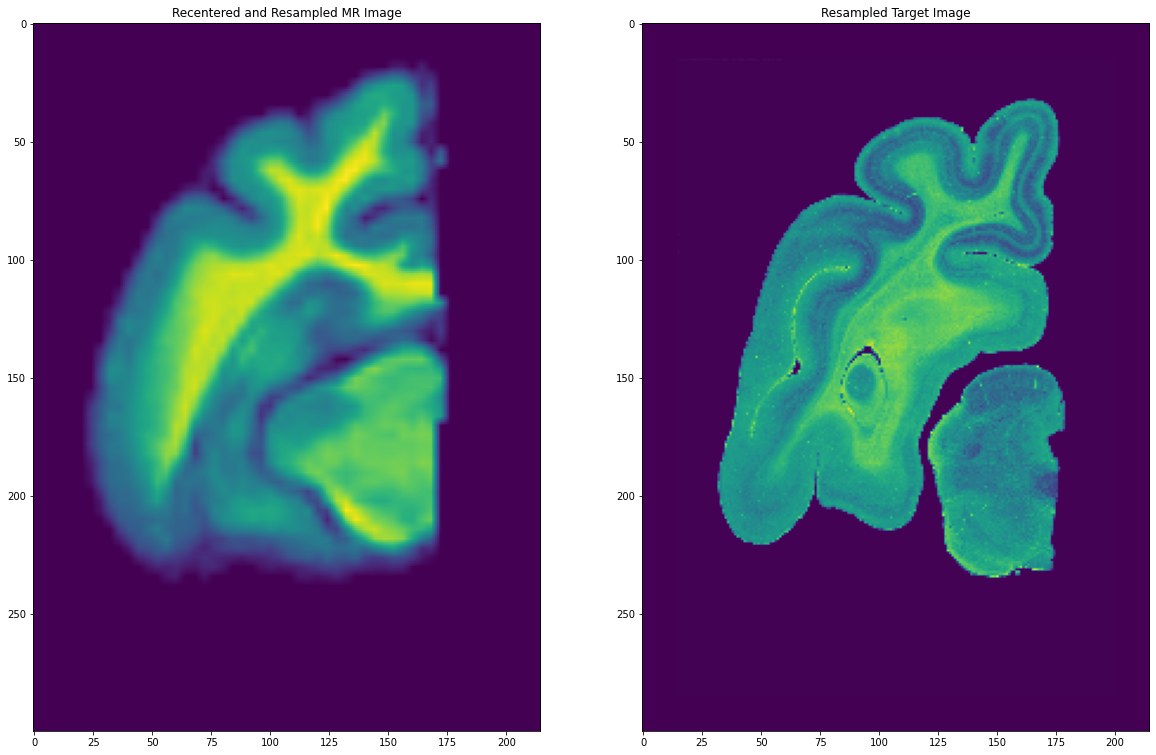

In [9]:
# display slices
plt.rcParams["figure.figsize"]=20,20
plt.figure()

# plot recentered and resampled MRI image
plt.subplot(1,2,1)
plt.title('Recentered and Resampled MR Image')
plt.imshow(np.transpose(sitk.GetArrayFromImage(mri_transform),(2,1,0))[:,:,10])


# plot resampled target image
plt.subplot(1,2,2)
plt.title('Resampled Target Image')
plt.imshow(np.transpose(sitk.GetArrayFromImage(target_resample),(2,1,0))[:,:,10])

plt.show()

# Histogram Match MR volume to histology

In [10]:
mri_transform = imgHM(mri_transform, target_resample, thresholdAtMean=True)
sitk.WriteImage(mri_transform, outDirPath+"mri_transform.nii")

# Slice alignment of histology to MR volume
Align histological slices to MR shape prior 

In [11]:
nIter=300

In [12]:
reconImg, lddmm = imgSliceAlign(target_resample, mri_transform, inSigma=99999999.0, numIterations=nIter)

# Write recon volume to file
sitk.WriteImage(reconImg, outDirPath + "recon0.nii")

# Write checkerboard
checkerImg = imgChecker(reconImg, mri_transform, False)
sitk.WriteImage(checkerImg, outDirPath+"checker0.nii")


Current parameters:
>    a               = 8 (smoothing kernel, a*(pixel_size))
>    p               = 2 (smoothing kernel power, p*2)
>    niter           = 150 (number of iterations)
>    epsilon         = 0.005 (gradient descent step size)
>    epsilonL        = 1e-07 (gradient descent step size, affine)
>    epsilonT        = 2e-05 (gradient descent step size, translation)
>    minbeta         = 0.0001 (smallest multiple of epsilon)
>    sigma           = [20.0] (matching term coefficient (0.5/sigma**2))
>    sigmaR          = 10.0 (regularization term coefficient (0.5/sigmaR**2))
>    nt              = 5 (number of time steps in velocity field)
>    do_lddmm        = 0 (perform LDDMM step, 0 = no, 1 = yes)
>    do_affine       = 2 (interleave linear registration: 0 = no, 1 = affine, 2 = rigid)
>    checkaffinestep = 1 (evaluate linear matching energy: 0 = no, 1 = yes)
>    im_norm_ms      = 0 (normalize image by mean and std: 0 = no, 1 = yes)
>    gpu_number      = None (index of

iteration: 47, E= 107024.422, Eim_t= 0.000, Eim_a= 107024.414, ER_xy= 0.000, ER_t= 0.0090, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iteration: 48, E= 106849.977, Eim_t= 0.000, Eim_a= 106849.969, ER_xy= 0.000, ER_t= 0.0090, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iteration: 49, E= 106848.047, Eim_t= 0.000, Eim_a= 106848.039, ER_xy= 0.000, ER_t= 0.0090, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iteration: 50, E= 106669.703, Eim_t= 0.000, Eim_a= 106669.695, ER_xy= 0.000, ER_t= 0.0090, ep_xy= 0.0000, ep_t= 0.0000, time= 0.45.
iteration: 51, E= 106668.289, Eim_t= 0.000, Eim_a= 106668.281, ER_xy= 0.000, ER_t= 0.0090, ep_xy= 0.0000, ep_t= 0.0000, time= 0.55.
iteration: 52, E= 106486.133, Eim_t= 0.000, Eim_a= 106486.125, ER_xy= 0.000, ER_t= 0.0090, ep_xy= 0.0000, ep_t= 0.0000, time= 0.47.
iteration: 53, E= 106485.375, Eim_t= 0.000, Eim_a= 106485.367, ER_xy= 0.000, ER_t= 0.0090, ep_xy= 0.0000, ep_t= 0.0000, time= 0.51.
iteration: 54, E= 106299.938, Eim_t= 0.000, Eim_a= 106299.930, ER_xy= 0.000,

iteration: 109, E= 100401.938, Eim_t= 0.000, Eim_a= 100401.930, ER_xy= 0.001, ER_t= 0.0069, ep_xy= 0.0000, ep_t= 0.0000, time= 0.58.
iteration: 110, E= 100197.930, Eim_t= 0.000, Eim_a= 100197.922, ER_xy= 0.001, ER_t= 0.0069, ep_xy= 0.0000, ep_t= 0.0000, time= 0.43.
iteration: 111, E= 100197.055, Eim_t= 0.000, Eim_a= 100197.047, ER_xy= 0.001, ER_t= 0.0068, ep_xy= 0.0000, ep_t= 0.0000, time= 0.57.
iteration: 112, E= 100001.125, Eim_t= 0.000, Eim_a= 100001.117, ER_xy= 0.001, ER_t= 0.0068, ep_xy= 0.0000, ep_t= 0.0000, time= 0.43.
iteration: 113, E= 100000.617, Eim_t= 0.000, Eim_a= 100000.609, ER_xy= 0.001, ER_t= 0.0068, ep_xy= 0.0000, ep_t= 0.0000, time= 0.56.
iteration: 114, E= 99809.883, Eim_t= 0.000, Eim_a= 99809.875, ER_xy= 0.001, ER_t= 0.0068, ep_xy= 0.0000, ep_t= 0.0000, time= 0.44.
iteration: 115, E= 99820.789, Eim_t= 0.000, Eim_a= 99820.781, ER_xy= 0.001, ER_t= 0.0067, ep_xy= 0.0000, ep_t= 0.0000, time= 0.57.
iteration: 116, E= 99642.039, Eim_t= 0.000, Eim_a= 99642.031, ER_xy= 0.00

iteration: 172, E= 97499.508, Eim_t= 0.000, Eim_a= 97499.500, ER_xy= 0.002, ER_t= 0.0067, ep_xy= 0.0000, ep_t= 0.0000, time= 0.41.
iteration: 173, E= 97497.477, Eim_t= 0.000, Eim_a= 97497.469, ER_xy= 0.002, ER_t= 0.0067, ep_xy= 0.0000, ep_t= 0.0000, time= 0.50.
iteration: 174, E= 97483.164, Eim_t= 0.000, Eim_a= 97483.156, ER_xy= 0.002, ER_t= 0.0067, ep_xy= 0.0000, ep_t= 0.0000, time= 0.42.
iteration: 175, E= 97481.438, Eim_t= 0.000, Eim_a= 97481.430, ER_xy= 0.002, ER_t= 0.0068, ep_xy= 0.0000, ep_t= 0.0000, time= 0.50.
iteration: 176, E= 97468.695, Eim_t= 0.000, Eim_a= 97468.688, ER_xy= 0.002, ER_t= 0.0068, ep_xy= 0.0001, ep_t= 0.0000, time= 0.43.
iteration: 177, E= 97466.867, Eim_t= 0.000, Eim_a= 97466.859, ER_xy= 0.002, ER_t= 0.0068, ep_xy= 0.0001, ep_t= 0.0000, time= 0.50.
iteration: 178, E= 97455.102, Eim_t= 0.000, Eim_a= 97455.094, ER_xy= 0.002, ER_t= 0.0068, ep_xy= 0.0001, ep_t= 0.0000, time= 0.42.
iteration: 179, E= 97452.523, Eim_t= 0.000, Eim_a= 97452.516, ER_xy= 0.002, ER_t= 0

iteration: 235, E= 97361.148, Eim_t= 0.000, Eim_a= 97361.141, ER_xy= 0.003, ER_t= 0.0072, ep_xy= 0.0001, ep_t= 0.0000, time= 0.52.
iteration: 236, E= 97360.492, Eim_t= 0.000, Eim_a= 97360.484, ER_xy= 0.003, ER_t= 0.0072, ep_xy= 0.0001, ep_t= 0.0000, time= 0.42.
iteration: 237, E= 97360.500, Eim_t= 0.000, Eim_a= 97360.492, ER_xy= 0.003, ER_t= 0.0072, ep_xy= 0.0001, ep_t= 0.0000, time= 0.51.
iteration: 238, E= 97360.055, Eim_t= 0.000, Eim_a= 97360.047, ER_xy= 0.003, ER_t= 0.0072, ep_xy= 0.0001, ep_t= 0.0000, time= 0.43.
iteration: 239, E= 97360.055, Eim_t= 0.000, Eim_a= 97360.047, ER_xy= 0.003, ER_t= 0.0072, ep_xy= 0.0001, ep_t= 0.0000, time= 0.50.
iteration: 240, E= 97359.766, Eim_t= 0.000, Eim_a= 97359.758, ER_xy= 0.003, ER_t= 0.0072, ep_xy= 0.0001, ep_t= 0.0000, time= 0.42.
iteration: 241, E= 97359.766, Eim_t= 0.000, Eim_a= 97359.758, ER_xy= 0.003, ER_t= 0.0072, ep_xy= 0.0001, ep_t= 0.0000, time= 0.50.
iteration: 242, E= 97359.602, Eim_t= 0.000, Eim_a= 97359.594, ER_xy= 0.003, ER_t= 0

iteration: 298, E= 97359.055, Eim_t= 0.000, Eim_a= 97359.047, ER_xy= 0.003, ER_t= 0.0072, ep_xy= 0.0000, ep_t= 0.0000, time= 0.43.
iteration: 299, E= 97359.008, Eim_t= 0.000, Eim_a= 97359.000, ER_xy= 0.003, ER_t= 0.0072, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.


Text(0, 0.5, 'Energy')

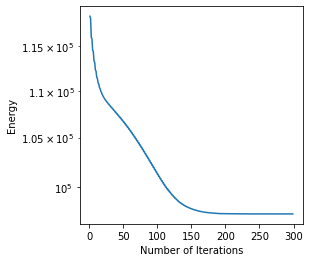

In [13]:
plt.figure(figsize = (4,4))
plt.plot(list(range(1,nIter)),lddmm.EAll)
plt.yscale("log")
plt.xlabel("Number of Iterations")
plt.ylabel("Energy")

# Rigid align MR to Histology

In [20]:
mri_affine, lddmm_affine = imgAffine(mri_transform, reconImg, numIterations=nIter)

sitk.WriteImage(mri_affine, outDirPath+"mri_affine.nii")

# Write checkerboard
checkerImg = imgChecker(reconImg, mri_affine, False)
sitk.WriteImage(checkerImg, outDirPath+"checker1.nii")


Current parameters:
>    a               = 8 (smoothing kernel, a*(pixel_size))
>    p               = 2 (smoothing kernel power, p*2)
>    niter           = 150 (number of iterations)
>    epsilon         = 0.005 (gradient descent step size)
>    epsilonL        = 1e-07 (gradient descent step size, affine)
>    epsilonT        = 2e-05 (gradient descent step size, translation)
>    minbeta         = 0.0001 (smallest multiple of epsilon)
>    sigma           = [20.0] (matching term coefficient (0.5/sigma**2))
>    sigmaR          = 10.0 (regularization term coefficient (0.5/sigmaR**2))
>    nt              = 5 (number of time steps in velocity field)
>    do_lddmm        = 0 (perform LDDMM step, 0 = no, 1 = yes)
>    do_affine       = 2 (interleave linear registration: 0 = no, 1 = affine, 2 = rigid)
>    checkaffinestep = 0 (evaluate linear matching energy: 0 = no, 1 = yes)
>    im_norm_ms      = 0 (normalize image by mean and std: 0 = no, 1 = yes)
>    gpu_number      = None (index of

iter: 23, E= 23329.768, ER= 0.000, EM= 23329.768, epd= 0.005, time= 2.38s.
iter: 24, E= 23329.746, ER= 0.000, EM= 23329.746, epd= 0.005, time= 2.38s.
iter: 25, E= 23329.734, ER= 0.000, EM= 23329.734, epd= 0.005, time= 2.37s.
iter: 26, E= 23329.717, ER= 0.000, EM= 23329.717, epd= 0.005, time= 2.38s.
iter: 27, E= 23329.707, ER= 0.000, EM= 23329.707, epd= 0.005, time= 2.40s.
iter: 28, E= 23329.701, ER= 0.000, EM= 23329.701, epd= 0.005, time= 2.37s.
iter: 29, E= 23329.695, ER= 0.000, EM= 23329.695, epd= 0.005, time= 2.42s.
iter: 30, E= 23329.689, ER= 0.000, EM= 23329.689, epd= 0.005, time= 2.37s.
iter: 31, E= 23329.686, ER= 0.000, EM= 23329.686, epd= 0.005, time= 2.41s.
iter: 32, E= 23329.688, ER= 0.000, EM= 23329.688, epd= 0.005, time= 2.36s.
iter: 33, E= 23329.688, ER= 0.000, EM= 23329.688, epd= 0.005, time= 2.38s.
iter: 34, E= 23329.686, ER= 0.000, EM= 23329.686, epd= 0.005, time= 2.37s.
iter: 35, E= 23329.686, ER= 0.000, EM= 23329.686, epd= 0.005, time= 2.44s.
iter: 36, E= 23329.684, E

iter: 90, E= 19782.576, ER= 0.000, EM= 19782.576, epd= 0.005, time= 2.34s.
iter: 91, E= 19781.180, ER= 0.000, EM= 19781.180, epd= 0.005, time= 2.38s.
iter: 92, E= 19779.643, ER= 0.000, EM= 19779.643, epd= 0.005, time= 2.41s.
iter: 93, E= 19778.625, ER= 0.000, EM= 19778.625, epd= 0.005, time= 2.35s.
iter: 94, E= 19777.490, ER= 0.000, EM= 19777.490, epd= 0.005, time= 2.33s.
iter: 95, E= 19776.461, ER= 0.000, EM= 19776.461, epd= 0.005, time= 2.34s.
iter: 96, E= 19775.484, ER= 0.000, EM= 19775.484, epd= 0.005, time= 2.33s.
iter: 97, E= 19774.537, ER= 0.000, EM= 19774.537, epd= 0.005, time= 2.36s.
iter: 98, E= 19773.533, ER= 0.000, EM= 19773.533, epd= 0.005, time= 2.35s.
iter: 99, E= 19772.693, ER= 0.000, EM= 19772.693, epd= 0.005, time= 2.38s.
iter: 100, E= 19771.721, ER= 0.000, EM= 19771.721, epd= 0.005, time= 2.34s.
iter: 101, E= 19770.979, ER= 0.000, EM= 19770.979, epd= 0.005, time= 2.32s.
iter: 102, E= 19769.592, ER= 0.000, EM= 19769.592, epd= 0.005, time= 2.34s.
iter: 103, E= 19768.90

Text(0, 0.5, 'Energy')

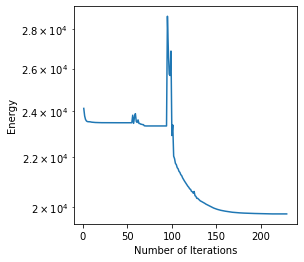

In [26]:
plt.figure(figsize = (4,4))
plt.plot(list(range(1,len(lddmm_affine.EAll)+1)),lddmm_affine.EAll)
plt.yscale("log")
plt.xlabel("Number of Iterations")
plt.ylabel("Energy")

# Simultaneous slice-slice and slice-MR alignment

In [29]:
outImg, lddmm_sim = imgSliceAlign(reconImg, mri_affine, numIterations=nIter)

# Write recon volume to file
sitk.WriteImage(outImg, outDirPath+"recon2.nii")

# Write checkerboard
checkerImg = imgChecker(outImg, mri_affine, False)
sitk.WriteImage(checkerImg, outDirPath+"checker2.nii")


Current parameters:
>    a               = 8 (smoothing kernel, a*(pixel_size))
>    p               = 2 (smoothing kernel power, p*2)
>    niter           = 150 (number of iterations)
>    epsilon         = 0.005 (gradient descent step size)
>    epsilonL        = 1e-07 (gradient descent step size, affine)
>    epsilonT        = 2e-05 (gradient descent step size, translation)
>    minbeta         = 0.0001 (smallest multiple of epsilon)
>    sigma           = [20.0] (matching term coefficient (0.5/sigma**2))
>    sigmaR          = 10.0 (regularization term coefficient (0.5/sigmaR**2))
>    nt              = 5 (number of time steps in velocity field)
>    do_lddmm        = 0 (perform LDDMM step, 0 = no, 1 = yes)
>    do_affine       = 2 (interleave linear registration: 0 = no, 1 = affine, 2 = rigid)
>    checkaffinestep = 1 (evaluate linear matching energy: 0 = no, 1 = yes)
>    im_norm_ms      = 0 (normalize image by mean and std: 0 = no, 1 = yes)
>    gpu_number      = None (index of

iteration: 47, E= 97222.359, Eim_t= 21373.520, Eim_a= 75848.844, ER_xy= 0.000, ER_t= 0.0003, ep_xy= 0.0000, ep_t= 0.0000, time= 0.56.
iteration: 48, E= 97184.602, Eim_t= 21352.861, Eim_a= 75831.742, ER_xy= 0.000, ER_t= 0.0003, ep_xy= 0.0000, ep_t= 0.0000, time= 0.45.
iteration: 49, E= 97182.422, Eim_t= 21347.723, Eim_a= 75834.695, ER_xy= 0.000, ER_t= 0.0003, ep_xy= 0.0000, ep_t= 0.0000, time= 0.57.
iteration: 50, E= 97144.828, Eim_t= 21327.543, Eim_a= 75817.281, ER_xy= 0.000, ER_t= 0.0003, ep_xy= 0.0000, ep_t= 0.0000, time= 0.46.
iteration: 51, E= 97142.500, Eim_t= 21322.213, Eim_a= 75820.289, ER_xy= 0.000, ER_t= 0.0003, ep_xy= 0.0000, ep_t= 0.0000, time= 0.57.
iteration: 52, E= 97104.812, Eim_t= 21302.371, Eim_a= 75802.438, ER_xy= 0.000, ER_t= 0.0003, ep_xy= 0.0000, ep_t= 0.0000, time= 0.45.
iteration: 53, E= 97103.828, Eim_t= 21297.576, Eim_a= 75806.250, ER_xy= 0.000, ER_t= 0.0004, ep_xy= 0.0000, ep_t= 0.0000, time= 0.56.
iteration: 54, E= 97065.344, Eim_t= 21277.771, Eim_a= 75787.57

iteration: 109, E= 96146.016, Eim_t= 20675.881, Eim_a= 75470.133, ER_xy= 0.000, ER_t= 0.0007, ep_xy= 0.0000, ep_t= 0.0000, time= 0.50.
iteration: 110, E= 96129.312, Eim_t= 20664.584, Eim_a= 75464.727, ER_xy= 0.000, ER_t= 0.0007, ep_xy= 0.0000, ep_t= 0.0000, time= 0.42.
iteration: 111, E= 96125.797, Eim_t= 20658.705, Eim_a= 75467.094, ER_xy= 0.000, ER_t= 0.0007, ep_xy= 0.0000, ep_t= 0.0000, time= 0.51.
iteration: 112, E= 96109.734, Eim_t= 20647.432, Eim_a= 75462.305, ER_xy= 0.000, ER_t= 0.0007, ep_xy= 0.0000, ep_t= 0.0000, time= 0.41.
iteration: 113, E= 96105.633, Eim_t= 20641.271, Eim_a= 75464.359, ER_xy= 0.000, ER_t= 0.0008, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iteration: 114, E= 96090.375, Eim_t= 20630.250, Eim_a= 75460.125, ER_xy= 0.000, ER_t= 0.0008, ep_xy= 0.0000, ep_t= 0.0000, time= 0.42.
iteration: 115, E= 96085.094, Eim_t= 20623.520, Eim_a= 75461.578, ER_xy= 0.000, ER_t= 0.0008, ep_xy= 0.0000, ep_t= 0.0000, time= 0.50.
iteration: 116, E= 96070.750, Eim_t= 20612.740, Eim_a= 

iteration: 170, E= 95803.734, Eim_t= 20358.824, Eim_a= 75444.914, ER_xy= 0.000, ER_t= 0.0012, ep_xy= 0.0000, ep_t= 0.0000, time= 0.43.
iteration: 171, E= 95801.875, Eim_t= 20357.043, Eim_a= 75444.828, ER_xy= 0.000, ER_t= 0.0012, ep_xy= 0.0000, ep_t= 0.0000, time= 0.51.
iteration: 172, E= 95799.375, Eim_t= 20354.824, Eim_a= 75444.547, ER_xy= 0.000, ER_t= 0.0012, ep_xy= 0.0000, ep_t= 0.0000, time= 0.43.
iteration: 173, E= 95797.484, Eim_t= 20353.053, Eim_a= 75444.430, ER_xy= 0.000, ER_t= 0.0012, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iteration: 174, E= 95795.078, Eim_t= 20350.926, Eim_a= 75444.156, ER_xy= 0.000, ER_t= 0.0012, ep_xy= 0.0000, ep_t= 0.0000, time= 0.43.
iteration: 175, E= 95793.273, Eim_t= 20349.211, Eim_a= 75444.062, ER_xy= 0.000, ER_t= 0.0013, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iteration: 176, E= 95790.992, Eim_t= 20347.193, Eim_a= 75443.797, ER_xy= 0.000, ER_t= 0.0013, ep_xy= 0.0000, ep_t= 0.0000, time= 0.45.
iteration: 177, E= 95789.164, Eim_t= 20345.475, Eim_a= 

iteration: 231, E= 95716.812, Eim_t= 20287.229, Eim_a= 75429.586, ER_xy= 0.000, ER_t= 0.0016, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iteration: 232, E= 95716.156, Eim_t= 20286.779, Eim_a= 75429.375, ER_xy= 0.000, ER_t= 0.0016, ep_xy= 0.0000, ep_t= 0.0000, time= 0.44.
iteration: 233, E= 95715.273, Eim_t= 20286.008, Eim_a= 75429.266, ER_xy= 0.000, ER_t= 0.0016, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iteration: 234, E= 95714.602, Eim_t= 20285.557, Eim_a= 75429.047, ER_xy= 0.000, ER_t= 0.0016, ep_xy= 0.0000, ep_t= 0.0000, time= 0.43.
iteration: 235, E= 95713.719, Eim_t= 20284.777, Eim_a= 75428.938, ER_xy= 0.000, ER_t= 0.0016, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iteration: 236, E= 95713.031, Eim_t= 20284.318, Eim_a= 75428.711, ER_xy= 0.000, ER_t= 0.0016, ep_xy= 0.0000, ep_t= 0.0000, time= 0.44.
iteration: 237, E= 95712.180, Eim_t= 20283.545, Eim_a= 75428.633, ER_xy= 0.000, ER_t= 0.0016, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iteration: 238, E= 95711.484, Eim_t= 20283.094, Eim_a= 

iteration: 292, E= 95673.906, Eim_t= 20254.613, Eim_a= 75419.297, ER_xy= 0.000, ER_t= 0.0019, ep_xy= 0.0000, ep_t= 0.0000, time= 0.44.
iteration: 293, E= 95673.500, Eim_t= 20254.270, Eim_a= 75419.234, ER_xy= 0.000, ER_t= 0.0019, ep_xy= 0.0000, ep_t= 0.0000, time= 0.53.
iteration: 294, E= 95673.328, Eim_t= 20254.184, Eim_a= 75419.148, ER_xy= 0.000, ER_t= 0.0019, ep_xy= 0.0000, ep_t= 0.0000, time= 0.44.
iteration: 295, E= 95672.906, Eim_t= 20253.834, Eim_a= 75419.070, ER_xy= 0.000, ER_t= 0.0019, ep_xy= 0.0000, ep_t= 0.0000, time= 0.54.
iteration: 296, E= 95672.734, Eim_t= 20253.748, Eim_a= 75418.984, ER_xy= 0.000, ER_t= 0.0019, ep_xy= 0.0000, ep_t= 0.0000, time= 0.44.
iteration: 297, E= 95672.305, Eim_t= 20253.400, Eim_a= 75418.906, ER_xy= 0.000, ER_t= 0.0019, ep_xy= 0.0000, ep_t= 0.0000, time= 0.52.
iteration: 298, E= 95672.125, Eim_t= 20253.311, Eim_a= 75418.812, ER_xy= 0.000, ER_t= 0.0019, ep_xy= 0.0000, ep_t= 0.0000, time= 0.44.
iteration: 299, E= 95671.695, Eim_t= 20252.961, Eim_a= 

Text(0, 0.5, 'Energy')

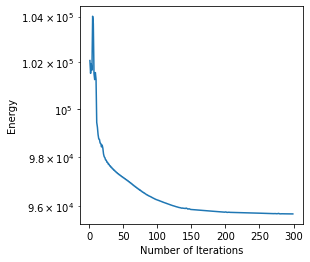

In [30]:
plt.figure(figsize = (4,4))
plt.plot(list(range(1,len(lddmm_sim.EAll)+1)),lddmm_sim.EAll)
plt.yscale("log")
plt.xlabel("Number of Iterations")
plt.ylabel("Energy")

In [37]:
inDirPath = '/Users/jennytrieu/Desktop/deafcats/'
import os
os.chdir(inDirPath)
recon_volume = inDirPath + 'recon2.nii'
recon_sitk = sitk.ReadImage(recon_volume)
print('recon: ', recon_sitk.GetSize())

checkered_volume = inDirPath + 'checker2.nii'
checkered_sitk = sitk.ReadImage(checkered_volume)
checkered_sitk.GetSize()
print('checkered: ', checkered_sitk.GetSize())

recon:  (300, 215, 68)
checkered:  (300, 215, 68)


In [32]:
# Visualize Histology and MRI slices
from ipywidgets import FloatSlider

def show_image(target_image, z_target):
    plt.figure(figsize=(4,10))
    plt.imshow(np.transpose(sitk.GetArrayFromImage(target_image),(2,1,0))[:,:,z_target])
    plt.title(f"Histology slice #{str(z_target)}")

interact(show_image,target_image = fixed(recon_sitk),
         z_target =widgets.IntSlider(min=0, max=67, step=1, value=10))
              

interactive(children=(IntSlider(value=10, description='z_target', max=67), Output()), _dom_classes=('widget-in…

<function __main__.show_image(target_image, z_target)>

In [38]:
# Visualize Histology and MRI slices
from ipywidgets import FloatSlider

def show_image(target_image, z_target, checkered_image, z_checkered):
    fig = plt.figure(figsize=(10,20))
    
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(np.transpose(sitk.GetArrayFromImage(target_image),(2,1,0))[:,:,z_target])
    ax1.set_title(f"Histology slice #{str(z_target)}")
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(np.transpose(sitk.GetArrayFromImage(checkered_image),(2,1,0))[:,:,z_checkered])
    ax2.set_title(f"slice #{str(z_checkered)}")
    
interact(show_image,
         target_image = fixed(recon_sitk),
         z_target =widgets.IntSlider(min=0, max=67, step=1, value=10),
         checkered_image = fixed(checkered_sitk),
         z_checkered = widgets.IntSlider(min=0, max=67, step=1, value=10))

interactive(children=(IntSlider(value=10, description='z_target', max=67), IntSlider(value=10, description='z_…

<function __main__.show_image(target_image, z_target, checkered_image, z_checkered)>